In [20]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

print("PyTorch Version:", torch.__version__)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

PyTorch Version: 2.0.1
Using device: cpu


In [21]:
# Hyperparameters and config

# Define the path to the image folder
data_dir = "data/AD_NC/train/AD-parent/"

batch_size = 32

# Downsample factor
downsample_factor = 2

# Original dimensions
original_width = 256
original_height = 240

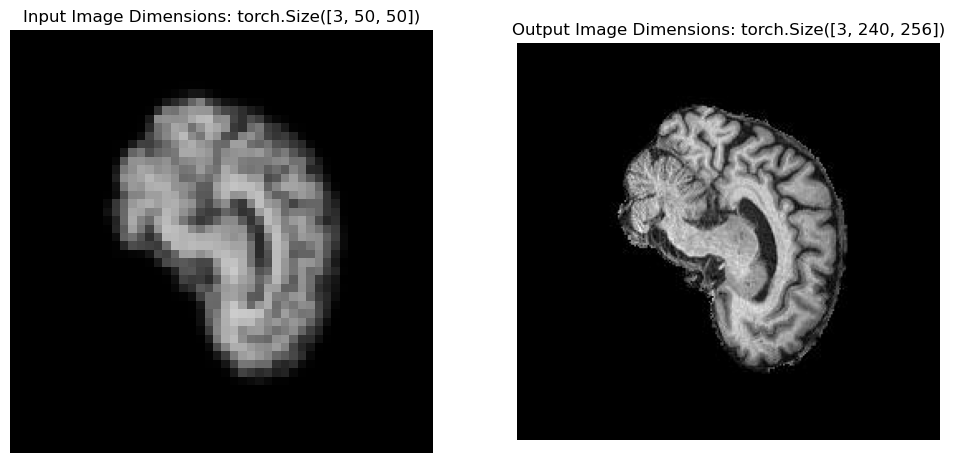

In [22]:
input_transform = transforms.Compose([
    transforms.Resize([original_height // downsample_factor, original_width // downsample_factor]),
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

output_transform = transforms.Compose([
    transforms.ToTensor(),
])

input_dataset = ImageFolder(root=data_dir, transform=input_transform)
output_dataset = ImageFolder(root=data_dir, transform=output_transform)

# Create a data loader to iterate through the dataset
input_data_loader = DataLoader(input_dataset, batch_size=batch_size)
output_data_loader = DataLoader(output_dataset, batch_size=batch_size)

for batch_input, batch_output in zip(input_data_loader, output_data_loader):
    # Downsampled images
    images_input, _ = batch_input
    # Original images
    images_output, _ = batch_output
    
    # Get the dimensions of the first input image
    first_input_image = images_input[0]
    input_image_dims = first_input_image.shape  # Shape will be (3, 224, 224) for RGB images
    
    # Get the dimensions of the first output image
    first_output_image = images_output[0]
    output_image_dims = first_output_image.shape  # Shape will be (3, 224, 224) for RGB images
    
    # Display the first input image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(first_input_image.permute(1, 2, 0))  # Convert tensor to numpy format (C, H, W) -> (H, W, C)
    plt.title(f"Input Image Dimensions: {input_image_dims}")
    plt.axis('off')  # Turn off axis labels
    
    # Display the first output image
    plt.subplot(1, 2, 2)
    plt.imshow(first_output_image.permute(1, 2, 0))  # Convert tensor to numpy format (C, H, W) -> (H, W, C)
    plt.title(f"Output Image Dimensions: {output_image_dims}")
    plt.axis('off')  # Turn off axis labels
    
    plt.show()
    
    break  # Stop after the first batch to print/display only the first pair of images